In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Conv2D, Concatenate, Input, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Попытка импортировать tensorflow_addons (для точного вращения)
try:
    import tensorflow_addons as tfa
    TFA_AVAILABLE = True
except Exception:
    print("tensorflow_addons not available — fallback to 90-degree rotations only.")
    TFA_AVAILABLE = False


# Paths
image_dir = "/kaggle/input/arialimagesdatasets/arialimages"
mask_dir = "/kaggle/input/arialimagesdatasets/ariallabels"

# Constants
IMG_SIZE = 256
BATCH_SIZE = 8
LRATE = 5e-4
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

print("Images:", len(os.listdir(image_dir)))
print("Masks:", len(os.listdir(mask_dir)))

print("Sample image file:", os.listdir(image_dir)[:3])
print("Sample mask file:", os.listdir(mask_dir)[:3])

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

2025-10-31 19:27:22.959927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761938842.999544   16245 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761938843.011456   16245 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow_addons not available — fallback to 90-degree rotations only.
Images: 30
Masks: 25
Sample image file: ['379.png', '314.png', '278.png']
Sample mask file: ['379.png', '314.png', '278.png']
TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# Load images and masks

def load_images_and_masks(image_dir, mask_dir, img_size=IMG_SIZE):
    images, masks = [], []
    image_names = []
    unlabeled_images = []

    mask_dict = {os.path.splitext(f)[0]: f for f in os.listdir(mask_dir)}

    for img_name in os.listdir(image_dir):
        stem = os.path.splitext(img_name)[0]
        img_path = os.path.join(image_dir, img_name)

        # Load image
        img = load_img(img_path, target_size=(img_size, img_size))
        img_arr = img_to_array(img).astype(np.float32) / 255.0
        
        if stem in mask_dict:
            mask_path = os.path.join(mask_dir, mask_dict[stem])
            mask = load_img(mask_path, target_size=(img_size, img_size), color_mode="grayscale")
            mask_arr = img_to_array(mask).astype(np.float32) / 255.0 # binary mask
            mask_arr = (mask_arr > 0.5).astype(np.float32)
    
            # Ensure mask shape matches image
            if img_arr.shape[:2] != mask_arr.shape[:2]:
                print(f"WARNING: Shape mismatch for {img_name} and {mask_dict[stem]} — skipping.")
                continue

            images.append(img_arr)
            masks.append(mask_arr)
            image_names.append(img_name)
        else:
            unlabeled_images.append(img_arr)

    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)
    unlabeled_images = np.array(unlabeled_images, dtype=np.float32)

    # Гарантируем (H, W, 1) для масок
    if masks.ndim == 3:
        masks = np.expand_dims(masks, axis=-1)

    print(f"Loaded {len(images)} labeled image–mask pairs")
    print(f"Found {len(unlabeled_images)} unlabeled images (for testing)")
    
    return images, masks, image_names, unlabeled_images

x_train, y_train, image_names, x_unlabeled = load_images_and_masks(image_dir, mask_dir)

Loaded 25 labeled image–mask pairs
Found 5 unlabeled images (for testing)


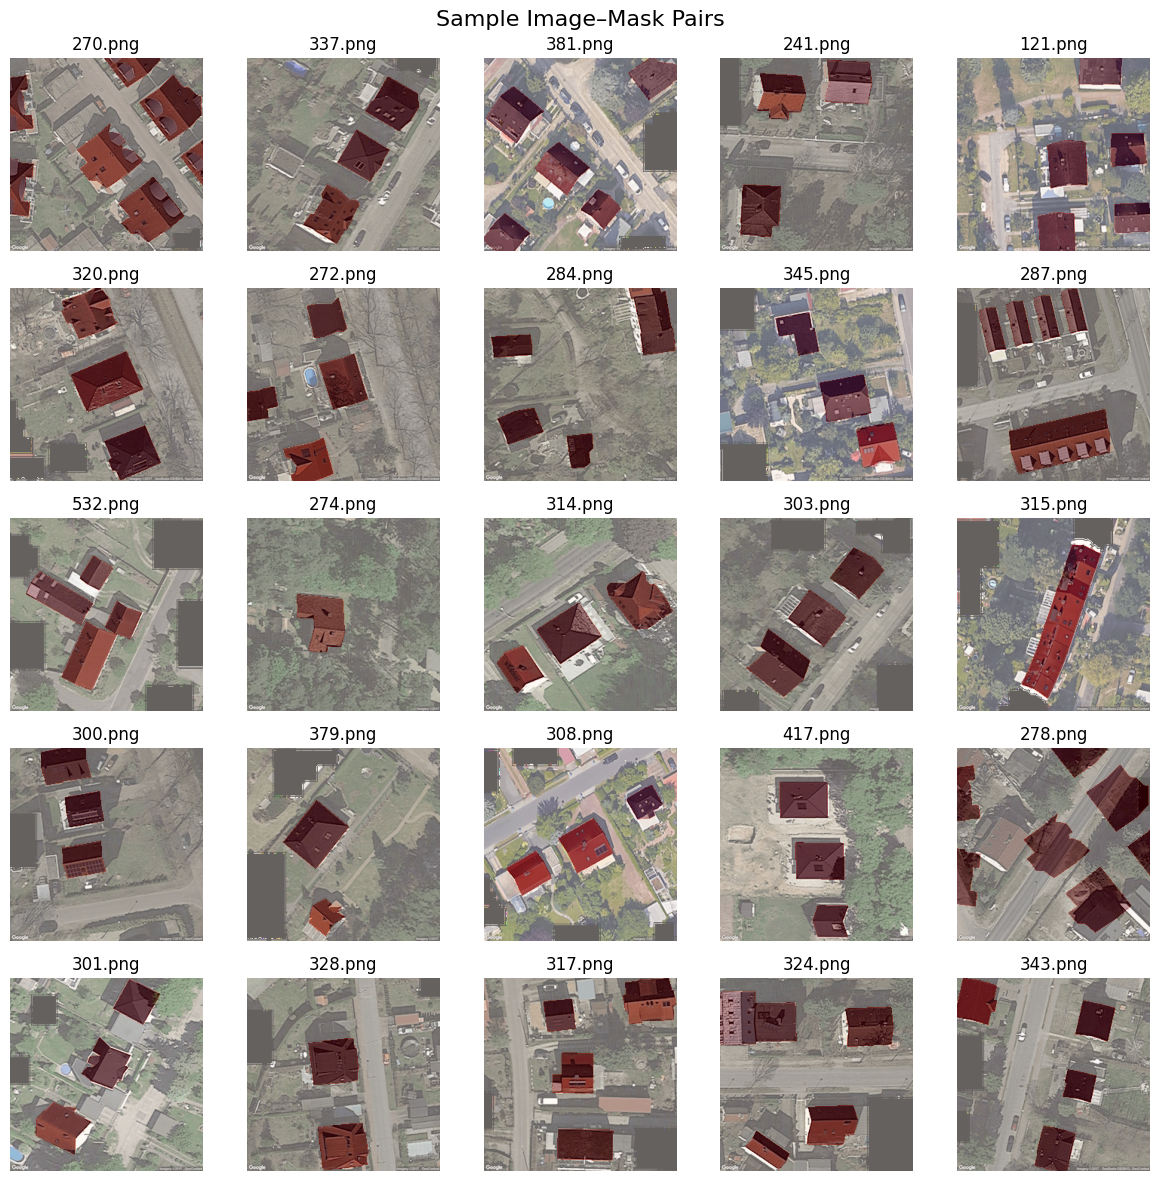

In [4]:
#plt.imshow(y_train[5].squeeze(), cmap='gray')
#plt.show()
import matplotlib.pyplot as plt
import random

def visualize_pairs(x, y, names=None, n=25):
    """
    Show n image–mask pairs in a grid (5×5).
    """
    n = min(n, len(x))
    indices = random.sample(range(len(x)), n)
    plt.figure(figsize=(12, 12))
    
    for i, idx in enumerate(indices):
        img = x[idx]
        mask = y[idx].squeeze()
        name = names[idx] if names else f"idx {idx}"
        
        plt.subplot(5, 5, i+1)
        plt.imshow(img)
        plt.imshow(mask, cmap='Reds', alpha=0.4)  # overlay mask in red
        plt.title(name[:20])  # show first part of filename
        plt.axis('off')
    
    plt.suptitle("Sample Image–Mask Pairs", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example use:
visualize_pairs(x_train, y_train, image_names, n=25)


In [5]:
bad_name = "278.png"
if bad_name in image_names:
    idx = image_names.index(bad_name)
    x_train = np.delete(x_train, idx, axis=0)
    y_train = np.delete(y_train, idx, axis=0)
    image_names.pop(idx)
    print(idx)

2


In [6]:
foreground_ratio = np.mean(y_train)
print(f"Foreground pixels ratio: {foreground_ratio:.3f}")

Foreground pixels ratio: 0.140


Our foreground pixels are only 14% of all pixels, which is quite imbalanced. That means:

- The network can predict “all background” (zeros) and still get 86% accuracy

- That’s why your predicted masks are uniform gray 

In [7]:
# Build U-Net with EfficientNetB0 backbone

def build_unet(input_shape=(256, 256, 3), freeze_encoder=True):
    
    base = EfficientNetB0(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape
    )
    
    #if freeze_encoder:
    #    base.trainable = False
        
    # Partial fine-tuning: freeze early layers, unfreeze later ones
    if freeze_encoder:
        for layer in base.layers[:200]:
            layer.trainable = False
        for layer in base.layers[200:]:
            layer.trainable = True
    else:
        base.trainable = True
        
    
    skip_names = [
        "block2a_expand_activation",  # 64×64
        "block3a_expand_activation",  # 32×32
        "block4a_expand_activation"   # 16×16
    ]
    skips = [base.get_layer(name).output for name in skip_names]

    x = base.output  # 8×8×1280
    decoder_filters = [256, 128, 64]

    for skip, f in zip(reversed(skips), decoder_filters):
        if skip.shape[1] is not None and x.shape[1] is not None:
            up_factor_h = skip.shape[1] // x.shape[1]
            up_factor_w = skip.shape[2] // x.shape[2]
            x = UpSampling2D(size=(up_factor_h, up_factor_w))(x)
        else:
            x = Resizing(tf.shape(skip)[1], tf.shape(skip)[2])(x)
        x = Concatenate()([x, skip])
        x = Conv2D(f, 3, padding='same', activation='relu')(x)
        x = Conv2D(f, 3, padding='same', activation='relu')(x)

    # Final upsample to match input
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    outputs = Conv2D(1, 1, activation='sigmoid')(x)

    return Model(inputs=base.input, outputs=outputs)

In [8]:
# Custom metrics

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [9]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return (1 - dice_weight) * bce + dice_weight * dice #bce + d_loss


In [10]:
#def focal_loss(y_true, y_pred, alpha=0.75, gamma=2.0):
#    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
#    bce_exp = tf.exp(-bce)
#    focal = alpha * (1 - bce_exp)**gamma * bce
#    return tf.reduce_mean(focal)
#
#model.compile(optimizer='adam', loss=focal_loss, metrics=[iou_coef, dice_coef])


In [11]:
def sobel_edges_tf(x):
    """Compute edge magnitude using Sobel filters in pure TF."""
    # Sobel kernels
    gx = tf.image.sobel_edges(x)[..., 0]  # horizontal
    gy = tf.image.sobel_edges(x)[..., 1]  # vertical
    return tf.sqrt(tf.square(gx) + tf.square(gy) + 1e-6)

def boundary_loss(y_true, y_pred):
    """Penalize difference between edge maps."""
    true_edges = sobel_edges_tf(y_true)
    pred_edges = sobel_edges_tf(y_pred)
    return tf.reduce_mean(tf.abs(true_edges - pred_edges))

def total_loss(y_true, y_pred):
    """Combined BCE + Dice + boundary-aware loss."""
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    b_loss = boundary_loss(y_true, y_pred)
    return bce + d_loss + 0.5 * b_loss

In [12]:
# -----------------------
# Аугментация: ОБЯЗАТЕЛЬНО одинаковая для изображения и маски
# -----------------------
def tf_rotate_both(img, mask, angle):
    """
    Если доступен tfa — используем tfa.image.rotate для произвольного угла.
    Иначе — применяем поворот на кратный 90 градусов (tf.image.rot90).
    angle в радианах.
    """
    if TFA_AVAILABLE:
        # tfa.image.rotate принимает угол в радианах
        img = tfa.image.rotate(img, angle, fill_mode='reflect')  # fill_mode по необходимости
        mask = tfa.image.rotate(mask, angle, fill_mode='nearest')  # для маски лучше nearest
    else:
        # fallback: округляем угол к ближайшему из {0, 90, 180, 270}
        # angle в радианах; преобразуем в количество квартов
        deg = angle * 180.0 / np.pi
        # вычисляем k = round(deg / 90) mod 4
        k = tf.math.floormod(tf.cast(tf.round(deg / 90.0), tf.int32), 4)
        img = tf.image.rot90(img, k=k)
        mask = tf.image.rot90(mask, k=k)
    return img, mask

@tf.function
def augment_image(img, mask):
    # img, mask: тензоры float32, маска имеет канал 1
    # Случайное горизонтальное отражение
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    # Случайное вращение: выбираем угол и применяем к обоим одним и тем же значением
    if tf.random.uniform(()) > 0.5:
        # угол от -90 до +90 градусов (в радианах)
        angle = tf.random.uniform((), minval=-np.pi/2, maxval=np.pi/2, dtype=tf.float32)
        img, mask = tf_rotate_both(img, mask, angle)
        
    # Random zoom
    if tf.random.uniform(()) > 0.5:
        scales = tf.random.uniform((), 0.8, 1.2)
        new_size = tf.cast(scales * IMG_SIZE, tf.int32)
        img = tf.image.resize(img, [new_size, new_size])
        mask = tf.image.resize(mask, [new_size, new_size])
        img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE, IMG_SIZE)
        mask = tf.image.resize_with_crop_or_pad(mask, IMG_SIZE, IMG_SIZE)
        
    # Яркость / контраст можно менять только изображение
    img = tf.image.random_brightness(img, 0.2)
    img = tf.clip_by_value(img, 0.0, 1.0)

    # Для маски: гарантируем бинарность после операций (особенно после интерполяции при вращении)
    mask = tf.clip_by_value(mask, 0.0, 1.0)
    mask = tf.round(mask)

    return img, mask

In [13]:
# -----------------------
# Создание tf.data.Dataset
# -----------------------
def create_dataset(images, masks, batch_size=BATCH_SIZE, augment=False, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images), seed=SEED)
    if augment:
        # map должен работать с тензорами и @tf.function augment_image — всё TF-операции
        dataset = dataset.map(lambda x, y: augment_image(x, y), num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [14]:
# -----------------------
# Визуализация аугментаций
# -----------------------
def visualize_augmentations(dataset,names=None, n=5):
    # Collect batches until we have at least n samples
    images, masks = [], []
    count = 0
    for batch in dataset:
        imgs, msks = batch
        imgs = imgs.numpy()
        msks = msks.numpy()
        for i in range(imgs.shape[0]):
            images.append(imgs[i])
            masks.append(msks[i].squeeze())
            count += 1
            if count >= n:
                break
        if count >= n:
            break

    images = np.array(images)
    masks = np.array(masks)

    # If names are provided, truncate or pad
    names_to_use = names[:n] if names is not None else None

    # Reuse visualize_pairs function
    visualize_pairs(images, masks, names=names_to_use, n=n)

In [15]:
# -----------------------
# Компиляция модели и колбэки
# -----------------------
model = build_unet()
model.compile(
    optimizer=tf.keras.optimizers.Adam( LRATE ),
    #loss='binary_crossentropy',
    #loss=bce_dice_loss, #Dice loss is much better for segmentation with imbalanced classes.
    loss = total_loss,
    metrics=['accuracy', dice_coef, iou_coef]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ModelCheckpoint("best_segmentation_model.h5", monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)
]

I0000 00:00:1761938849.537071   16245 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761938849.537799   16245 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [16]:
# -----------------------
# Train / val split и создание датасетов
# -----------------------
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=SEED)

train_ds = create_dataset(x_tr, y_tr, augment=True, shuffle=True)
val_ds = create_dataset(x_val, y_val, augment=False, shuffle=False)

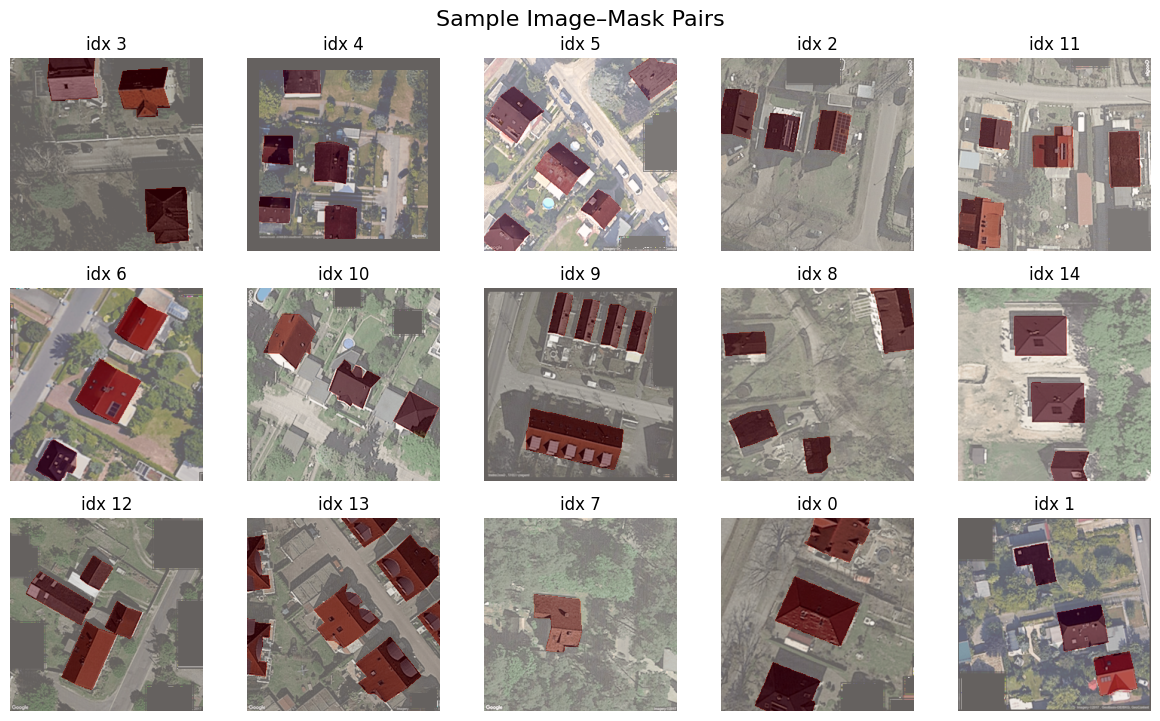

In [17]:
# Augmentation visualization

# Предпросмотр аугментаций
#visualize_augmentations(train_ds, n=5)
visualize_augmentations(train_ds, n=15)

In [18]:
# -----------------------
# Обучение
# -----------------------
# Phase 1: warmup with frozen encoder
for layer in model.layers:
    if "efficientnet" in layer.name:
        layer.trainable = False

history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=120, 
    callbacks=callbacks
)

# Phase 2: fine-tune top encoder layers
for layer in model.layers:
    if "block6" in layer.name or "block7" in layer.name:
        layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(2e-4), loss=total_loss,
              metrics=['accuracy', dice_coef, iou_coef])

#model.fit(train_ds, validation_data=val_ds, epochs=150, callbacks=callbacks)
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=130,
    callbacks=callbacks,
    #verbose=1
)

Epoch 1/120


I0000 00:00:1761938883.198975   16299 service.cc:148] XLA service 0x7dc9e40677a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761938883.199023   16299 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761938883.199028   16299 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761938886.011606   16299 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1761938888.095450   16299 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761938888.241044   16299 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/3 ━━━━━━━━━━━━━━━━━━━━ 2:02 61s/step - accuracy: 0.1480 - dice_coef: 0.2420 - iou_coef: 0.1377 - loss: 1.8012

I0000 00:00:1761938917.018566   16299 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.3260 - dice_coef: 0.1861 - iou_coef: 0.1056 - loss: 1.7773

E0000 00:00:1761938921.236429   16297 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761938921.381608   16297 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761938928.443811   16297 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761938928.716083   16297 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.4041 - dice_coef: 0.1592 - iou_coef: 0.0899 - loss: 1.7562  

E0000 00:00:1761938950.467464   16297 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761938950.618257   16297 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761938950.759319   16297 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_loss improved from inf to 1.30288, saving model to best_segmentation_model.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 104s 21s/step - accuracy: 0.4431 - dice_coef: 0.1458 - iou_coef: 0.0821 - loss: 1.7457 - val_accuracy: 0.8676 - val_dice_coef: 0.1383 - val_iou_coef: 0.0743 - val_loss: 1.3029 - learning_rate: 5.0000e-04
Epoch 2/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8645 - dice_coef: 0.1567 - iou_coef: 0.0851 - loss: 1.3242 
Epoch 2: val_loss did not improve from 1.30288
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.8649 - dice_coef: 0.1596 - iou_coef: 0.0869 - loss: 1.3241 - val_accuracy: 0.8676 - val_dice_coef: 0.1369 - val_iou_coef: 0.0735 - val_loss: 1.3048 - learning_rate: 5.0000e-04
Epoch 3/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8579 - dice_coef: 0.1484 - iou_coef: 0.0803 - loss: 1.3278 
Epoch 3: val_loss did not improve from 1.30288
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.8577 - dice_coef: 0.1518 - iou_coef: 0.0823 - loss: 1.3

In [19]:
# Save the full model (architecture + weights)
model.save("final_segmentation_model.h5")

# Later we can load it with:
# from tensorflow.keras.models import load_model
# model = load_model("final_apple_segmentation_model.h5", custom_objects={'dice_coef': dice_coef, 'iou_coef': iou_coef})

In [20]:
val_loss, val_acc, val_dice, val_iou = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8391 - dice_coef: 0.2635 - iou_coef: 0.1517 - loss: 1.1800
Validation Loss: 1.1800, Dice: 0.2635, IoU: 0.1517


In [21]:
# Predict masks for unlabeled images
preds = model.predict(x_unlabeled)

# Convert to binary masks (0 or 1)
binary_preds = (preds > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [22]:
import cv2
import math

def postprocess_mask(pred, threshold=0.5):
    """
    Convert model output (float mask) into a clean binary mask.
    - Threshold at 0.5
    - Morphological closing (remove small holes)
    """
    pred_bin = (pred > threshold).astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    pred_bin = cv2.morphologyEx(pred_bin, cv2.MORPH_CLOSE, kernel)
    return pred_bin

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


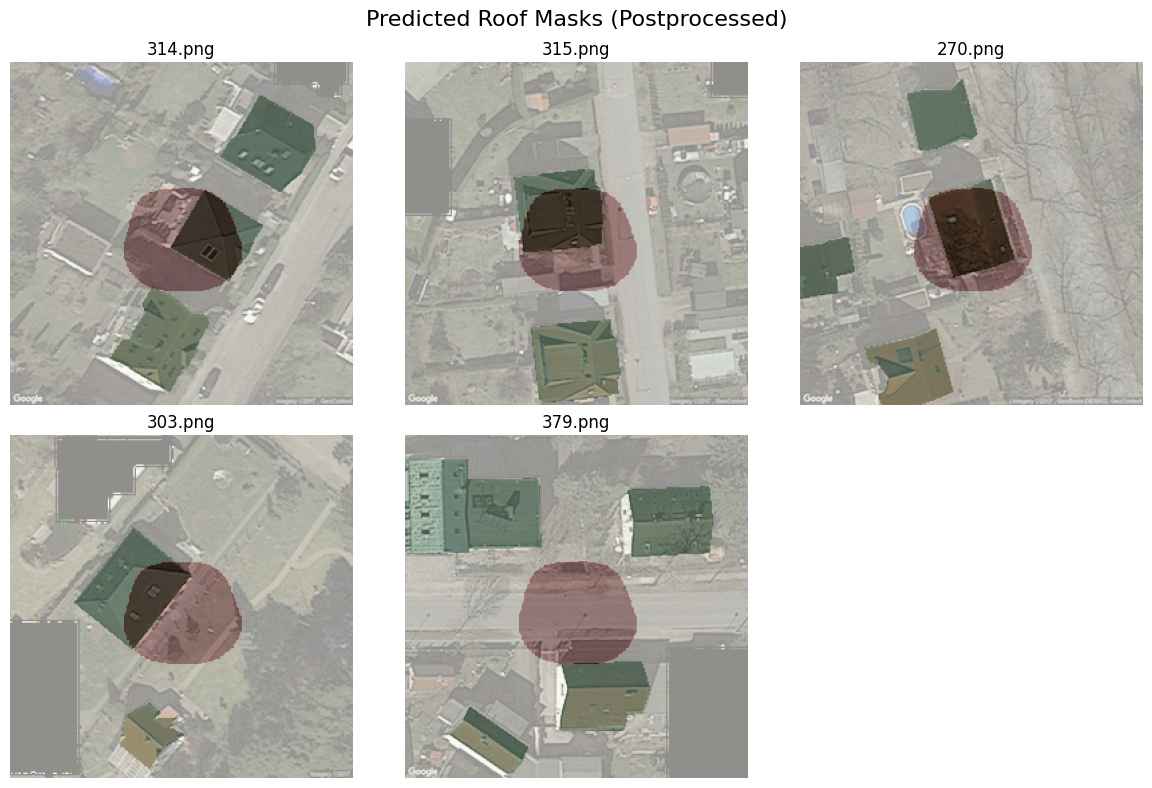

In [23]:
def visualize_predictions(model, x_input, names=None, y_true=None, n=9, threshold=0.5):
    """
    Visualize model predictions with postprocessing.
    Optionally show ground truth masks for comparison.
    """
    preds = model.predict(x_input)
    n = min(n, len(x_input))
    indices = random.sample(range(len(x_input)), n)

    cols = int(math.ceil(math.sqrt(n)))
    rows = int(math.ceil(n / cols))
    
    plt.figure(figsize=(4 * cols, 4 * rows))
    
    for i, idx in enumerate(indices):
        img = x_input[idx]
        raw_pred = preds[idx].squeeze()
        post_pred = postprocess_mask(raw_pred, threshold=threshold)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.imshow(post_pred, cmap='Reds', alpha=0.4)

        if y_true is not None:
            true_mask = y_true[idx].squeeze()
            plt.imshow(true_mask, cmap='Greens', alpha=0.3)

        if names:
            plt.title(names[idx][:25])
        plt.axis('off')

    plt.suptitle("Predicted Roof Masks (Postprocessed)", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, x_val, names=image_names, y_true=y_val, n=9)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


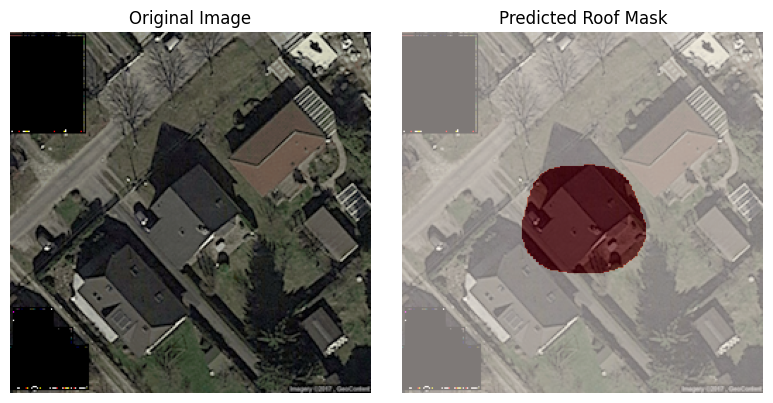

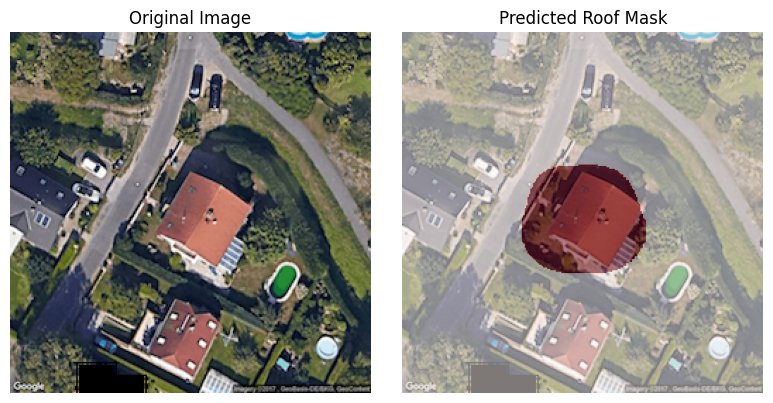

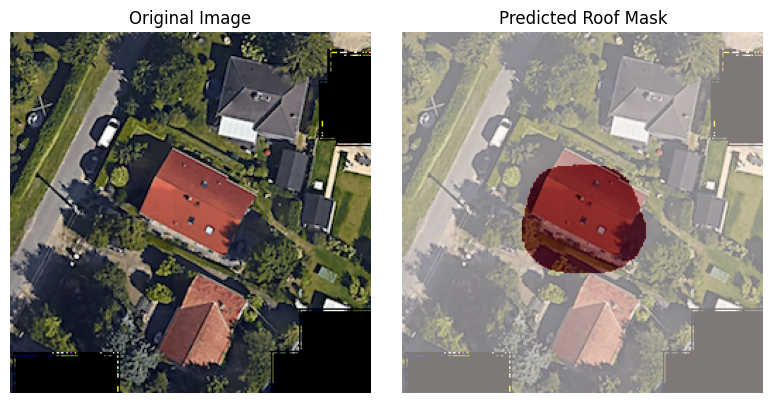

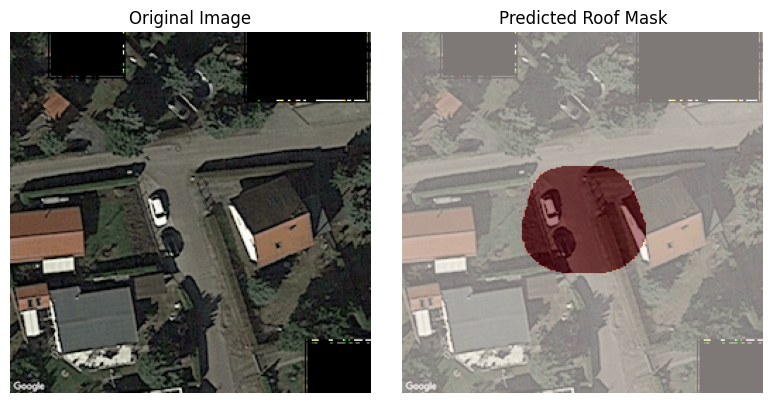

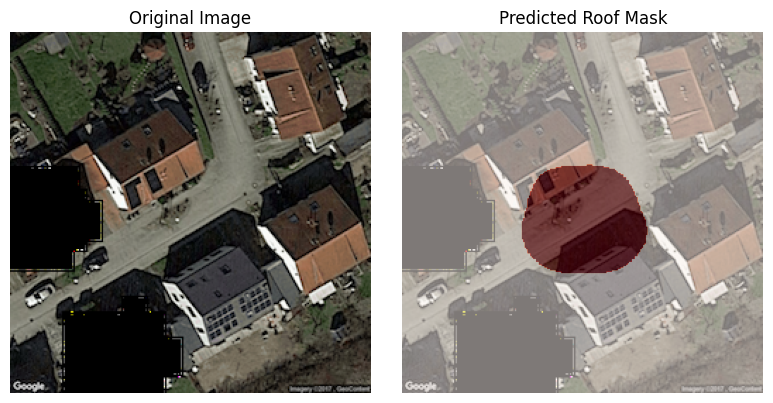

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Get model predictions on unlabeled data
raw_preds = model.predict(x_unlabeled)
binary_preds = np.array([postprocess_mask(p.squeeze(), threshold=0.5) for p in raw_preds])

# Visualize a few examples
for i in range(min(5, len(x_unlabeled))):
    img = x_unlabeled[i]
    mask = binary_preds[i]

    plt.figure(figsize=(8, 4))

    # Left: original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    # Right: predicted mask overlay
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(mask, cmap='Reds', alpha=0.5)
    plt.title("Predicted Roof Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

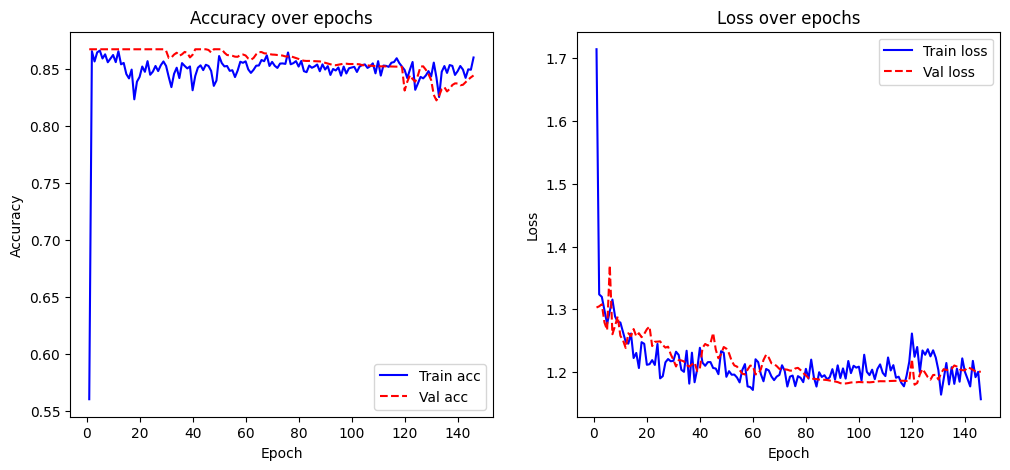

In [25]:
def plot_training(history1, history2=None):
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    if history2:
        acc += history2.history['accuracy']
        val_acc += history2.history['val_accuracy']
        loss += history2.history['loss']
        val_loss += history2.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Train acc')
    plt.plot(epochs, val_acc, 'r--', label='Val acc')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Train loss')
    plt.plot(epochs, val_loss, 'r--', label='Val loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Вызов
plot_training(history, history_finetune)

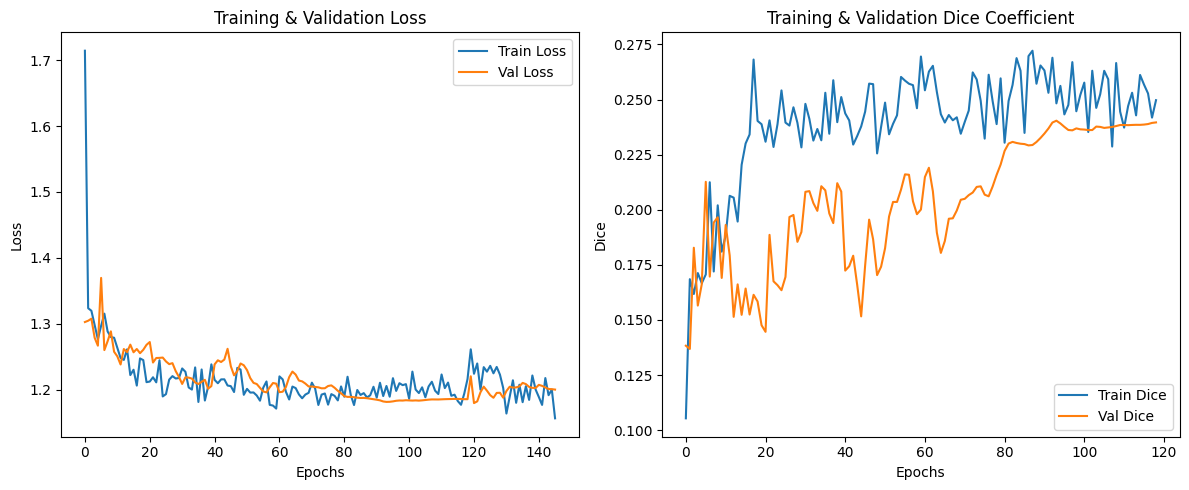

In [26]:
import matplotlib.pyplot as plt


def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # --- Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # --- Dice Coefficient (or Accuracy) ---
    if 'dice_coef' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['dice_coef'], label='Train Dice')
        plt.plot(history.history['val_dice_coef'], label='Val Dice')
        plt.title("Training & Validation Dice Coefficient")
        plt.xlabel("Epochs")
        plt.ylabel("Dice")
        plt.legend()
    elif 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title("Training & Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Use it:
plot_training_history(history)

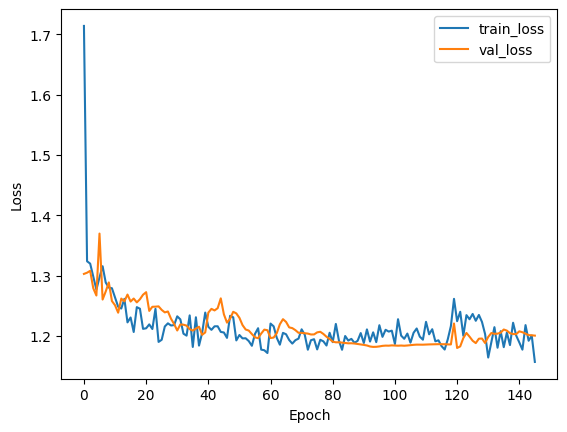

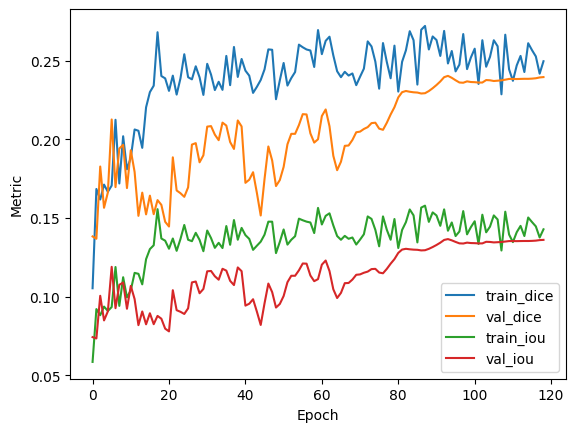

In [27]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot metrics (Dice, IoU, Accuracy)
plt.plot(history.history['dice_coef'], label='train_dice')
plt.plot(history.history['val_dice_coef'], label='val_dice')
plt.plot(history.history['iou_coef'], label='train_iou')
plt.plot(history.history['val_iou_coef'], label='val_iou')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()

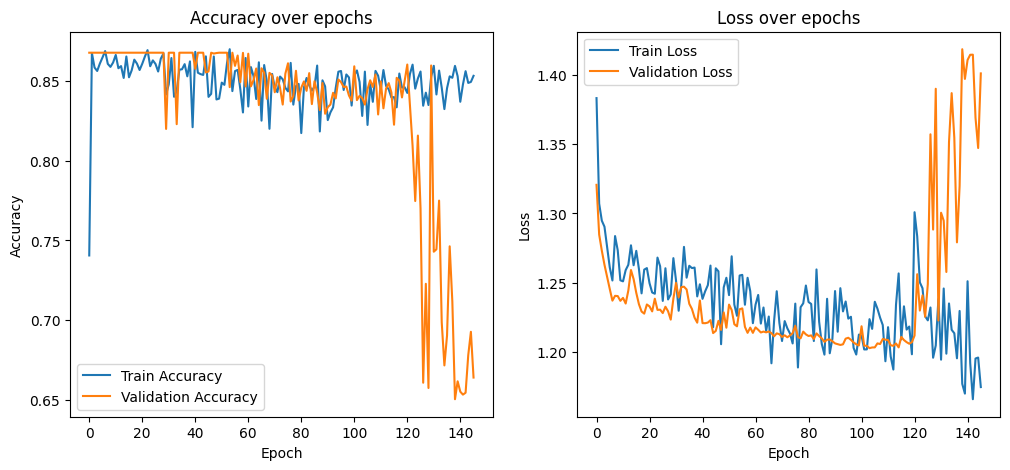

In [27]:
# Plot accuracy & loss

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

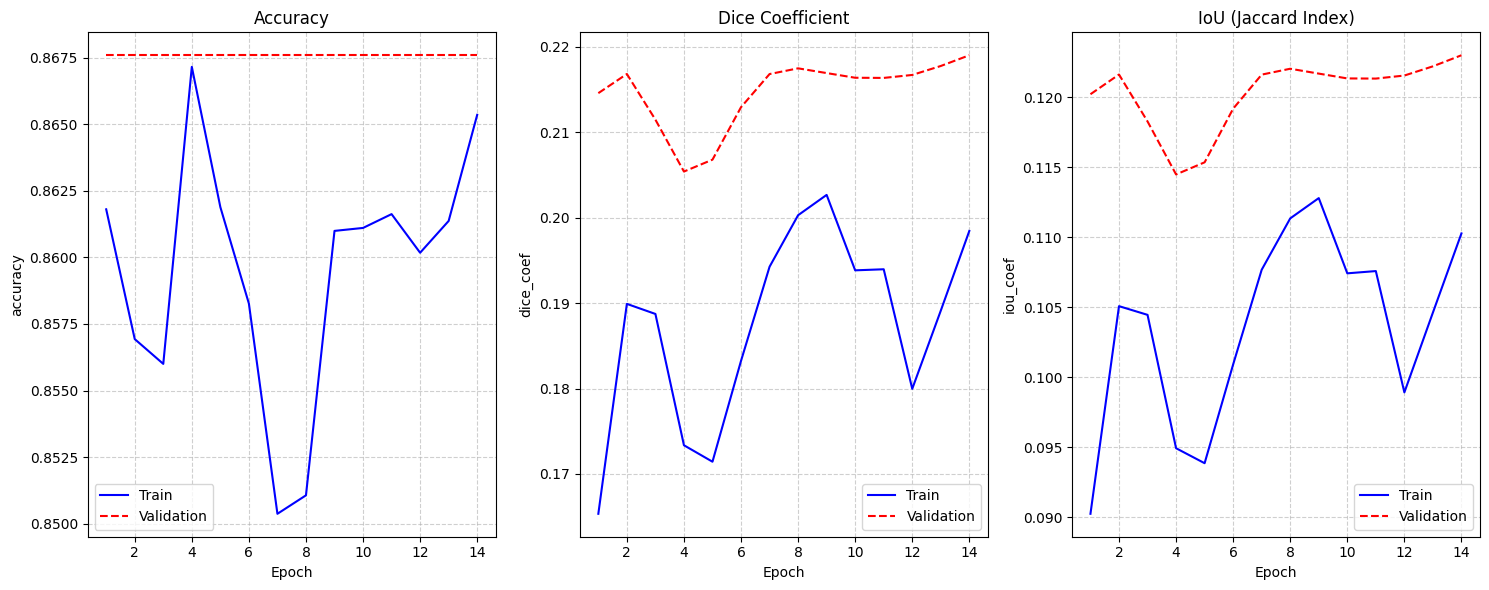

In [27]:
import matplotlib.pyplot as plt

def plot_segmentation_training(history):
    metrics = ['accuracy', 'dice_coef', 'iou_coef']
    titles = ['Accuracy', 'Dice Coefficient', 'IoU (Jaccard Index)']

    plt.figure(figsize=(15, 6))

    for i, (metric, title) in enumerate(zip(metrics, titles)):
        train_values = history.history.get(metric, [])
        val_values = history.history.get(f'val_{metric}', [])
        epochs = range(1, len(train_values) + 1)

        plt.subplot(1,3, i + 1)
        plt.plot(epochs, train_values, 'b-', label='Train')
        plt.plot(epochs, val_values, 'r--', label='Validation')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Call this after training
plot_segmentation_training(history)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_predictions(model, images, masks, num=3):
    idxs = np.random.choice(len(images), num)
    for i in idxs:
        img = images[i]
        true_mask = masks[i].squeeze()
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0].squeeze()
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.title("Input image")
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground truth mask")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted mask")
        plt.axis('off')

        plt.show()

# Example usage
show_predictions(model, x_val, y_val, num=3)


In [ ]:
import matplotlib.pyplot as plt
import random

def visualize_predictions(model, x_val, y_val, num_samples=3):
    indices = random.sample(range(len(x_val)), num_samples)
    preds = model.predict(x_val[indices])
    
    for i, idx in enumerate(indices):
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.title("Original Image")
        plt.imshow(x_val[idx])
        plt.axis('off')
        
        plt.subplot(1,3,2)
        plt.title("True Mask")
        plt.imshow(y_val[idx].squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1,3,3)
        plt.title("Predicted Mask")
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()

visualize_predictions(model, x_val, y_val)


In [ ]:
# Predict unlabeled images
 
for i, img in enumerate(x_unlabeled):
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0].squeeze()
    pred_mask = (pred_mask > 0.5).astype(np.float32)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Unlabeled image {i+1}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted apple mask")
    plt.axis('off')
    plt.show()

# Task characteristics:

- Scale 256×256.

- Objects (roofs) have hard edges, diverse shapes, and high color/texture variation.

- Background can include roads, vegetation, shadows, etc.

- Class imbalance — background dominates, but less extreme than tiny-object tasks.

U-Net++, DeepLabV3+, or SegFormer (transformer-based) give better boundary accuracy.

If you stay with U-Net, use EfficientNetB3/B4 or ResNet50 encoder for richer features.

Input resolution should be at least 512×512 for visible roof edges.

Data preprocessing

Normalize images (divide by 255).

Resample masks to match the exact image size.

Consider patch extraction if your source images are very large (e.g. 2048×2048 → 512×512 crops).

Keep track of coordinates if you plan to reconstruct the full-size prediction later.

4️⃣ Augmentation

Critical for roofs:

Random rotation (90°, 180°, 270°)

Horizontal/vertical flip

Brightness, contrast, and hue variation

Random scale/zoom (simulate different altitudes)

Slight blurring or shadow simulation helps with real-world satellite noise.

5️⃣ Metrics

For roof detection, track:

IoU (Intersection over Union) — the most relevant for segmentation accuracy.

F1 score / Dice coefficient

Optionally Boundary IoU (for sharp edges).

6️⃣ Post-processing

Predictions can be refined by:

Thresholding at 0.5 (or adjusted by validation).

Morphological closing to fill small gaps.

(Optional) Vectorization with cv2.findContours() to export roof polygons (GIS-style).

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, Lambda, Input, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import cv2

# -----------------------
# Constants
# -----------------------
IMG_SIZE = 256
BATCH_SIZE = 4
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# -----------------------
# Load data
# -----------------------
image_dir = "/kaggle/input/arialimagesdatasets/arialimages"
mask_dir = "/kaggle/input/arialimagesdatasets/ariallabels"




def load_images_and_masks(image_dir, mask_dir, img_size=IMG_SIZE):
    images, masks = [], []
    mask_dict = {os.path.splitext(f)[0]: f for f in os.listdir(mask_dir)}

    for img_name in os.listdir(image_dir):
        stem = os.path.splitext(img_name)[0]
        if stem not in mask_dict:
            continue
        img = cv2.imread(os.path.join(image_dir, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        mask = cv2.imread(os.path.join(mask_dir, mask_dict[stem]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size))
        img = img / 255.0
        mask = (mask / 255.0 > 0.5).astype(np.float32)
        images.append(img)
        masks.append(mask[..., np.newaxis])
    return np.array(images), np.array(masks)

x, y = load_images_and_masks(image_dir, mask_dir)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=SEED)


# -----------------------
# U-Net with aligned decoder
# -----------------------
def build_unet(input_shape=(256, 256, 3)):
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

    # Extract encoder layers for skip connections
    skips = [
        base.get_layer("block2a_expand_activation").output,  # 64x64
        base.get_layer("block3a_expand_activation").output,  # 32x32
        base.get_layer("block4a_expand_activation").output,  # 16x16
    ]

    x = base.output  # 8x8 (bottleneck)
    # Decoder
    for skip in reversed(skips):
        # Upsample
        x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)

        # Align skip feature map size to match the upsampled feature map
        def resize_like(inputs):
            src, target = inputs
            target_shape = tf.shape(target)[1:3]
            return tf.image.resize(src, target_shape, method="bilinear")

        skip = Lambda(resize_like)([skip, x])

        # Concatenate & refine
        x = Concatenate()([x, skip])
        x = Conv2D(128, 3, activation="relu", padding="same")(x)
        x = Conv2D(128, 3, activation="relu", padding="same")(x)

    # Final upsample
    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = Conv2D(64, 3, activation="relu", padding="same")(x)
    outputs = Conv2D(1, 1, activation="sigmoid")(x)

    model = Model(inputs=base.input, outputs=outputs)
    return model




# -----------------------
# Loss functions
# -----------------------
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def edge_loss(y_true, y_pred):
    sobel_x = tf.constant([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=tf.float32)
    sobel_y = tf.constant([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=tf.float32)
    sobel_x, sobel_y = sobel_x[..., tf.newaxis, tf.newaxis], sobel_y[..., tf.newaxis, tf.newaxis]
    y_true_ex = tf.nn.conv2d(y_true, sobel_x, [1,1,1,1], "SAME")
    y_true_ey = tf.nn.conv2d(y_true, sobel_y, [1,1,1,1], "SAME")
    y_pred_ex = tf.nn.conv2d(y_pred, sobel_x, [1,1,1,1], "SAME")
    y_pred_ey = tf.nn.conv2d(y_pred, sobel_y, [1,1,1,1], "SAME")
    y_true_edges = tf.sqrt(y_true_ex**2 + y_true_ey**2)
    y_pred_edges = tf.sqrt(y_pred_ex**2 + y_pred_ey**2)
    return tf.reduce_mean(tf.abs(y_true_edges - y_pred_edges))

def boundary_loss(y_true, y_pred):
    bce  = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    edge = edge_loss(y_true, y_pred)
    return bce + 0.5*dice + 0.5*edge

def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    TP = tf.reduce_sum(y_true_f*y_pred_f)
    FP = tf.reduce_sum((1-y_true_f)*y_pred_f)
    FN = tf.reduce_sum(y_true_f*(1-y_pred_f))
    return 1 - (TP + smooth)/(TP + alpha*FP + beta*FN + smooth)



def combined_loss(y_true, y_pred):
    return dice_loss(y_true,y_pred) + tversky_loss(y_true,y_pred) + 0.1*boundary_loss(y_true,y_pred)


model = build_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=boundary_loss,
              metrics=['accuracy', dice_coef, iou_coef])

# -----------------------
# Augmentation
# -----------------------
def augment_image(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        k = tf.random.uniform((), 0, 4, dtype=tf.int32)
        img = tf.image.rot90(img, k)
        mask = tf.image.rot90(mask, k)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_brightness(img, 0.2)
    return img, mask

def create_dataset(images, masks, batch_size=BATCH_SIZE, augment=False, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    if shuffle:
        dataset = dataset.shuffle(len(images), seed=SEED)
    if augment:
        dataset = dataset.map(lambda x, y: augment_image(x, y), num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)
    return dataset

# -----------------------
# Split data and datasets
# -----------------------
#x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=SEED)
train_ds = create_dataset(x_train, y_train, augment=True)
val_ds = create_dataset(x_val, y_val, augment=False)

# -----------------------
# Callbacks
# -----------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint("best_roof_segmentation.h5", monitor='val_loss', save_best_only=True)
]

# -----------------------
# Training
# -----------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)



In [ ]:
def visualize_predictions(model, x_input, n=5, thr=0.5):
    preds = model.predict(x_input[:n])
    preds_bin = (preds > thr).astype(np.uint8)
    plt.figure(figsize=(12, 3*n))
    for i in range(n):
        plt.subplot(n, 3, 3*i+1)
        plt.imshow(x_input[i])
        plt.title("Input")
        plt.axis("off")
        plt.subplot(n, 3, 3*i+2)
        plt.imshow(y_val[i].squeeze(), cmap="gray")
        plt.title("True Mask")
        plt.axis("off")
        plt.subplot(n, 3, 3*i+3)
        plt.imshow(x_input[i])
        plt.imshow(preds_bin[i].squeeze(), cmap="Reds", alpha=0.4)
        plt.title("Predicted")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(model, x_val, n=5)


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_predictions(model, x_input, n=5, morph_kernel=3, threshold=0.5):
    """
    Visualize predictions from the model on x_input.

    Parameters:
        model : Keras model
        x_input : NumPy array of images (H, W, 3)
        n : number of images to visualize
        morph_kernel : size of morphological kernel for mask cleanup
        threshold : threshold to binarize predictions
    """
    preds = model.predict(x_input[:n])
    
    # Binarize
    binary_preds = (preds > threshold).astype(np.uint8)

    # Morphological cleanup
    kernel = np.ones((morph_kernel, morph_kernel), np.uint8)
    for i in range(n):
        mask = binary_preds[i,...,0]  # shape (H,W)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        binary_preds[i] = np.expand_dims(mask, axis=-1)  # restore channel dim

    # Plot
    plt.figure(figsize=(12, 3*n))
    for i in range(n):
        img = x_input[i]
        mask = binary_preds[i].squeeze()
        
        # Original image
        plt.subplot(n, 2, i*2+1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')
        
        # Overlay mask
        plt.subplot(n, 2, i*2+2)
        #plt.imshow(img)
        plt.imshow(mask, cmap='Reds', alpha=1)
        plt.title("Predicted Mask")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_predictions(model, x_val, n=5)